In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest,f_classif,VarianceThreshold,SelectFromModel,RFECV

In [48]:
from sklearn.model_selection import train_test_split


X_train = pd.read_csv('/content/drive/MyDrive/9417group/X_train.csv')
y_train = pd.read_csv('/content/drive/MyDrive/9417group/y_train.csv')
X_test1 = pd.read_csv('/content/drive/MyDrive/9417group/X_test_1.csv')
X_test2 = pd.read_csv('/content/drive/MyDrive/9417group/X_test_2.csv')
y_test2_reduced = pd.read_csv('/content/drive/MyDrive/9417group/y_test_2_reduced.csv')

In [49]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test1 shape: {X_test1.shape}")
print(f"X_test2 shape: {X_test2.shape}")
print(f"y_test2_reduced shape: {y_test2_reduced.shape}")

X_train shape: (10000, 300)
y_train shape: (10000, 1)
X_test1 shape: (1000, 300)
X_test2 shape: (2020, 300)
y_test2_reduced shape: (202, 1)


In [50]:
print(f"X_train missing values: {X_train.isna().sum().sum()}")
print(f"y_train missing values: {y_train.isna().sum().sum()}")
print(f"Duplicate rows in X_train: {X_train.duplicated().sum()}")

X_train missing values: 0
y_train missing values: 0
Duplicate rows in X_train: 0


Class imbalance ratio (max/min): 746.50


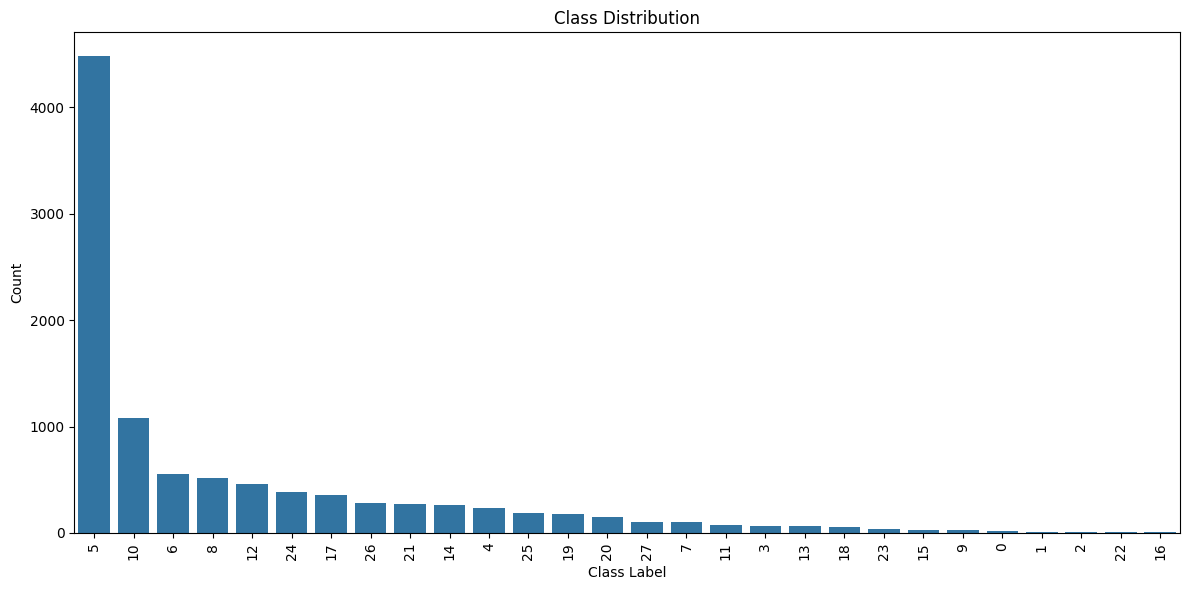

In [51]:
# check y_train distribution
class_distribution = y_train['label'].value_counts()
class_imbalance = class_distribution.max() / class_distribution.min()
print(f"Class imbalance ratio (max/min): {class_imbalance:.2f}")

plt.figure(figsize=(12, 6))
sns.countplot(x='label', data=y_train, order=y_train['label'].value_counts().index)
plt.title('Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()

In [52]:
# check feature distribution
feature_stats = X_train.describe()
print(feature_stats.T.head())

     count      mean       std      min       25%       50%       75%     max
0  10000.0 -0.021449  0.986789  -8.1638 -0.629273 -0.026099  0.581712  4.5750
1  10000.0 -0.000912  1.008141 -11.9820 -0.601035  0.026874  0.627327  4.2322
2  10000.0  0.012368  1.009709  -3.5020 -0.652678 -0.042700  0.620073  6.5868
3  10000.0  0.045447  0.985909  -4.7040 -0.567387  0.069475  0.677163  3.8679
4  10000.0  0.034961  0.988168  -7.0178 -0.589565  0.026490  0.639463  7.7052


In [53]:
# standardize the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test1=pd.DataFrame(scaler.transform(X_test1), columns=X_train.columns)
X_test2=pd.DataFrame(scaler.transform(X_test2), columns=X_train.columns)

In [54]:
# delete small variance features
var_thresh = VarianceThreshold(threshold=0.1)
transformed_data = var_thresh.fit_transform(X_train)
retained_features = X_train.columns[var_thresh.get_support()]
X_train = X_train[retained_features]
print(len(retained_features))

300


delete features: []
all features: 300
keep features: 300


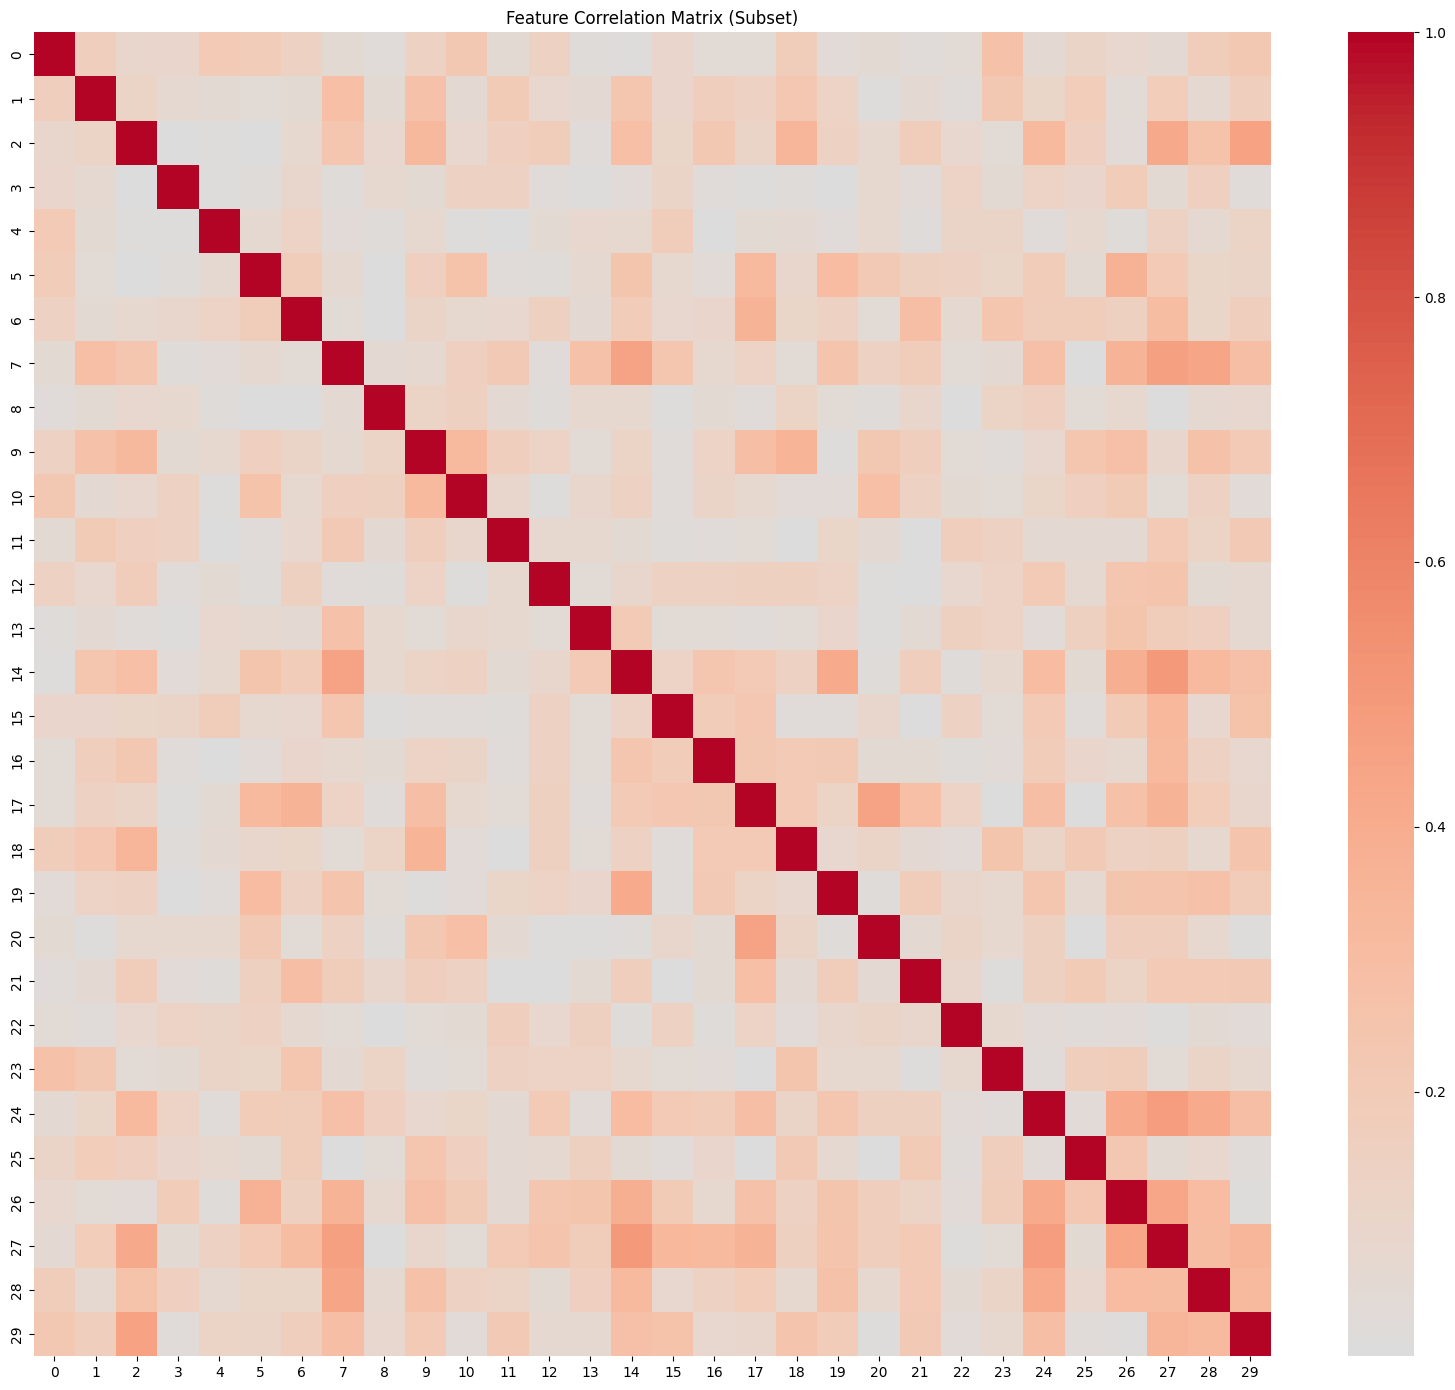

In [55]:
# search corr
correlation_matrix = X_train.corr().abs()
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix.iloc[:30, :30], annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix (Subset)')
plt.tight_layout()

# filter highly correlated features
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
threshold = 0.8
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print(f"delete features: {to_drop}")
print(f"all features: {X_train.shape[1]}")
X_train = X_train.drop(columns=to_drop)
print(f"keep features: {X_train.shape[1]}")

In [56]:
# set class weight
class_counts = y_train['label'].value_counts()
total_samples = len(y_train)
class_weight = {class_label: total_samples / (len(class_counts) * count)
                 for class_label, count in class_counts.items()}

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
param_grid = {'C': [ 0.1, 0.2,0.3]}
grid_search = GridSearchCV(
    LogisticRegression(penalty='l1', solver='liblinear', class_weight=class_weight),
    param_grid, cv=5, scoring='f1_weighted',verbose=2, n_jobs=-1
)
grid_search.fit(X_train, y_train['label'])
best_C = grid_search.best_params_['C']
print(f"best c: {best_C}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits


Selected 150 out of 300 features


<ipython-input-35-1079fc0997bc>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


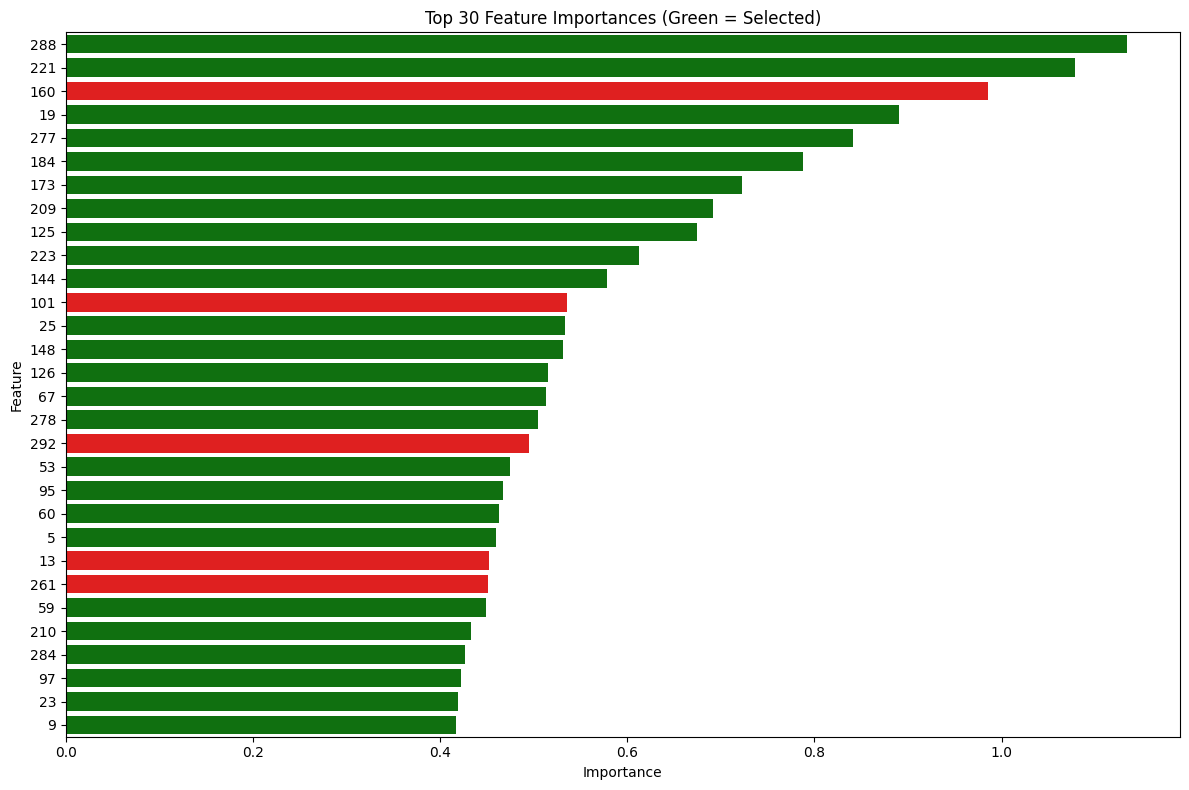

In [35]:
from sklearn.linear_model import LogisticRegression

selector = SelectFromModel(
    LogisticRegression(penalty='l1', C=0.2, solver='liblinear', class_weight=class_weight),
    threshold='median',
)

selector.fit_transform(X_train, y_train['label'])

feature_mask = selector.get_support()


selected_features = X_train.columns[feature_mask]

importances = abs(selector.estimator_.coef_[0])
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances,
    'Selected': feature_mask
})

feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

print(f"Selected {len(selected_features)} out of {X_train.shape[1]} features")

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature',
            data=feature_importance_df.head(30),
            palette=['green' if x else 'red' for x in feature_importance_df.head(30)['Selected']])
plt.title('Top 30 Feature Importances (Green = Selected)')
plt.tight_layout()


cv scores: [0.752  0.758  0.751  0.7425 0.754 ]
mean: 0.7515
std: 0.0051
              precision    recall  f1-score   support

           0       0.36      0.89      0.52        18
           1       0.86      0.86      0.86         7
           2       0.78      1.00      0.88         7
           3       0.49      0.83      0.62        65
           4       0.68      0.70      0.69       238
           5       0.94      0.91      0.93      4479
           6       0.91      0.95      0.93       553
           7       0.54      0.83      0.66       103
           8       0.80      0.80      0.80       516
           9       0.46      0.44      0.45        25
          10       0.89      0.75      0.81      1081
          11       0.59      0.95      0.73        78
          12       0.68      0.58      0.62       457
          13       0.36      0.65      0.46        62
          14       0.24      0.18      0.21       264
          15       0.76      1.00      0.87        26
        

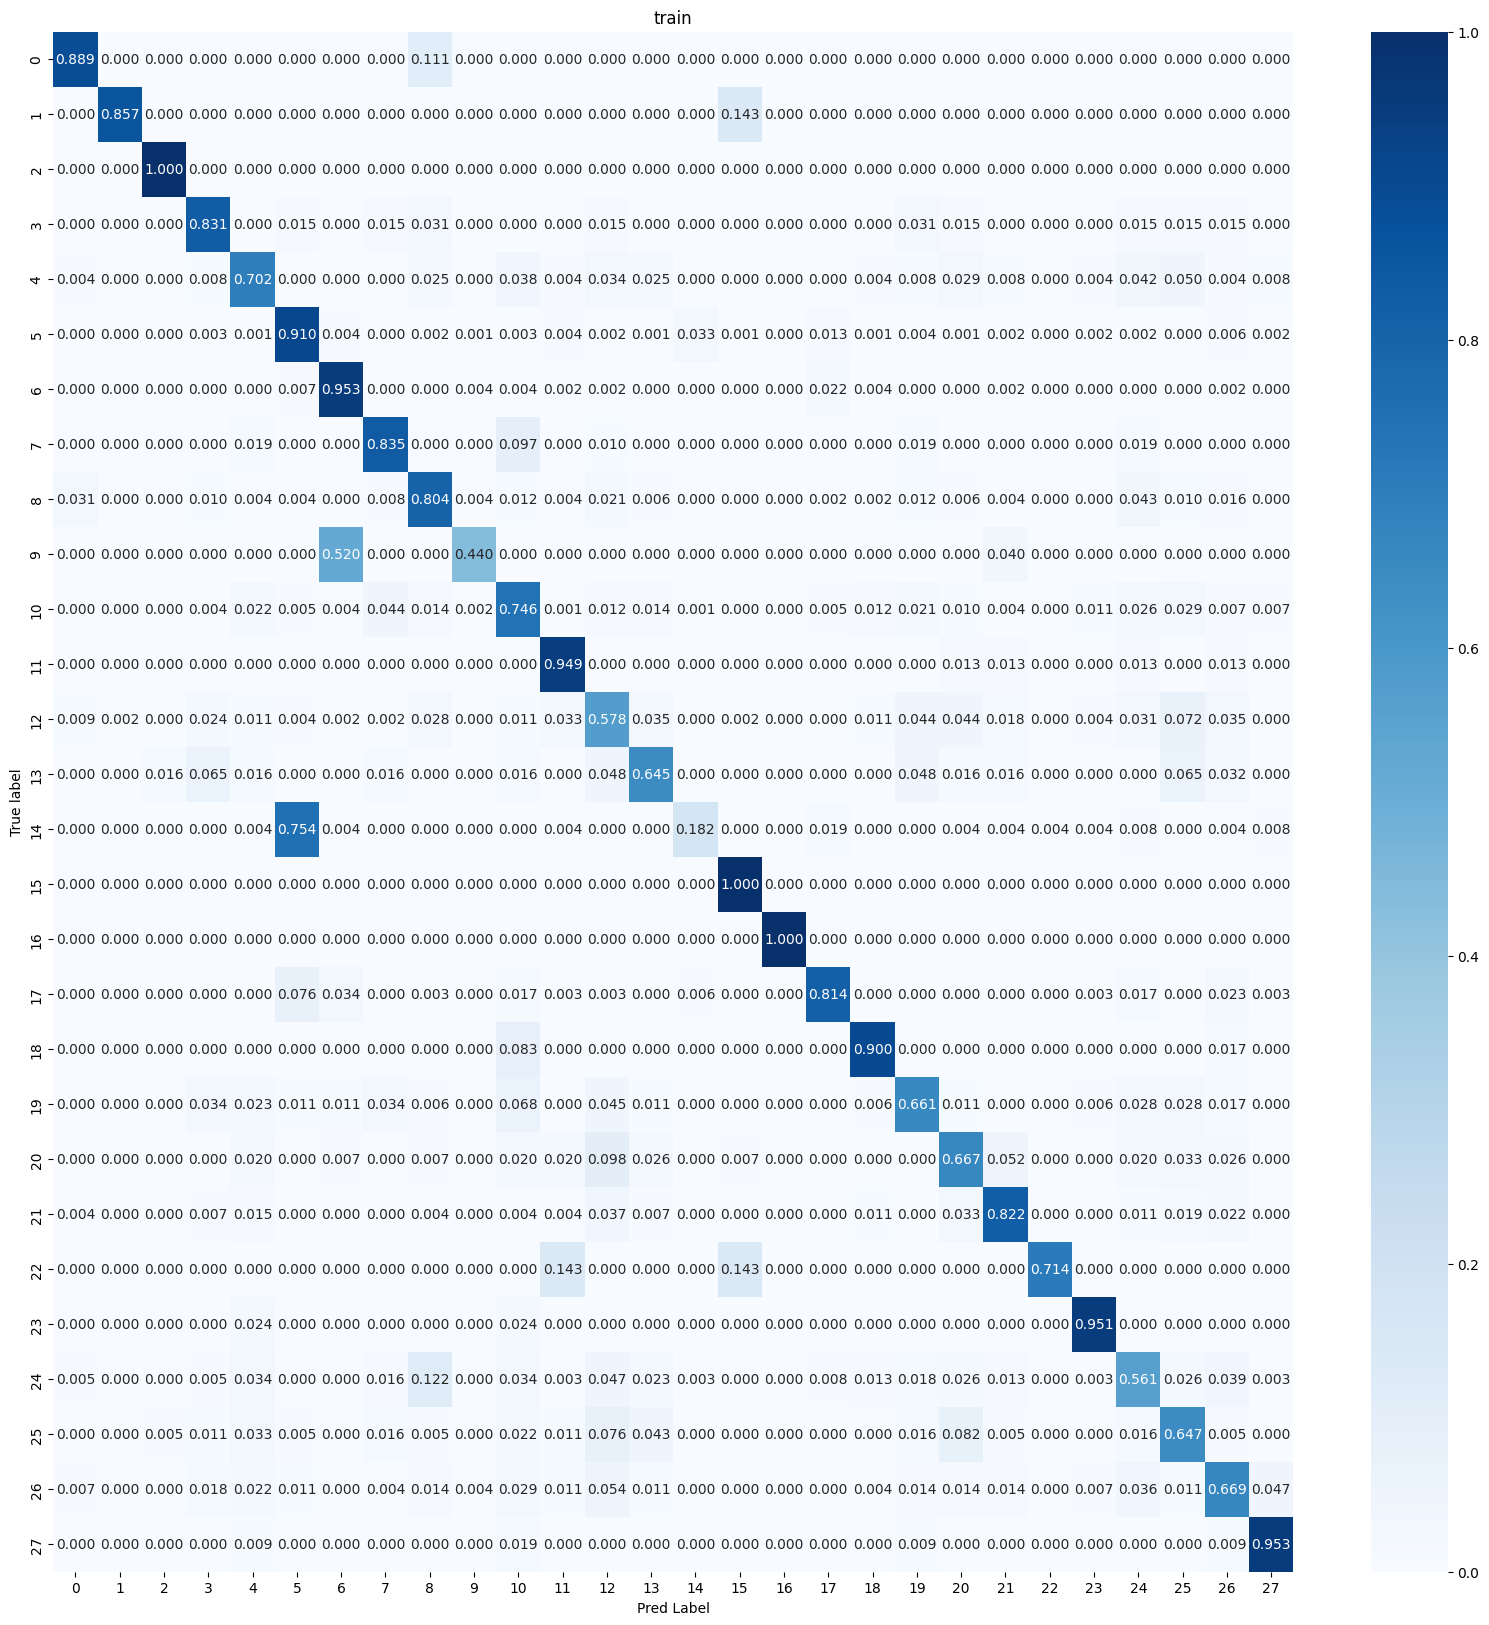

              precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           2       1.00      0.00      0.00         1
           3       1.00      0.00      0.00         1
           4       0.80      1.00      0.89         4
           5       0.60      1.00      0.75         9
           6       0.50      1.00      0.67         3
           7       0.90      0.64      0.75        14
           8       0.88      0.79      0.84        29
           9       1.00      0.00      0.00         3
          10       0.25      1.00      0.40         2
          11       0.80      0.89      0.84         9
          12       0.75      0.56      0.64        43
          13       0.17      1.00      0.29         1
          14       1.00      0.17      0.29         6
          15       1.00      1.00      1.00         1
          17       0.89      0.80      0.84        10
          18       0.00      0.00      0.00         1
          19       0.40    

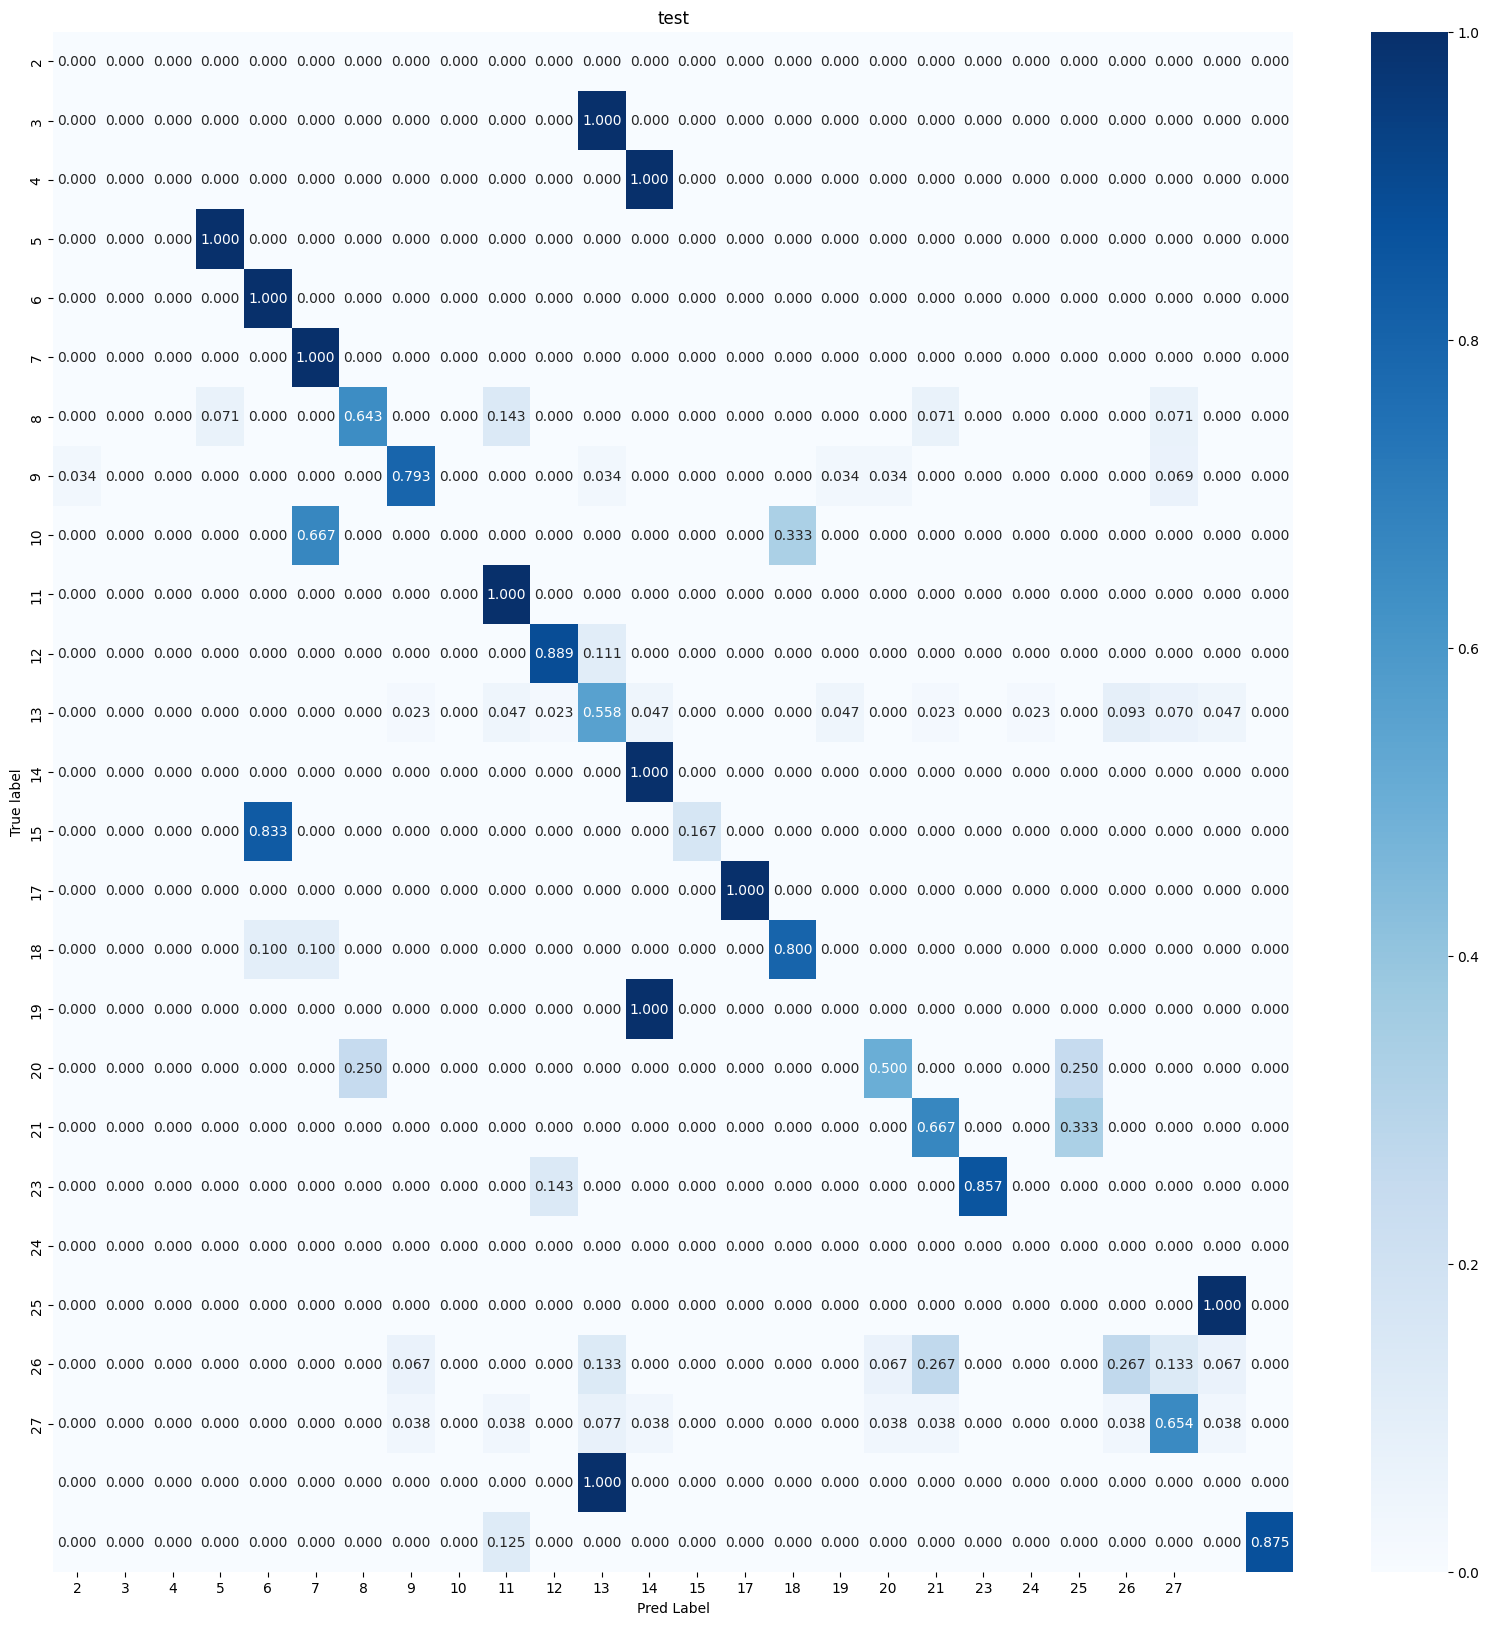

In [37]:
# sift features

X_train1 = X_train[selected_features]
base_model=LogisticRegression(penalty='l1', C=0.2, solver='liblinear', class_weight=class_weight)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(base_model, X_train1, y_train['label'], cv=cv, scoring='accuracy')

print(f"cv scores: {cv_scores}")
print(f"mean: {cv_scores.mean():.4f}")
print(f"std: {cv_scores.std():.4f}")


base_model.fit(X_train1, y_train['label'])

# train predict
y_pred = base_model.predict(X_train1)

# report
print(classification_report(y_train['label'], y_pred))

classes=np.unique(y_train).astype(str)
plt.figure(figsize=(20, 20))
sns.heatmap(confusion_matrix(y_train['label'], y_pred,normalize='true'),
            annot=True, fmt='.3f', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('train')
plt.ylabel('True label')
plt.xlabel('Pred Label')
plt.show()

X_test2_reduced = X_test2.loc[y_test2_reduced.index]
X_test2_1 = X_test2_reduced[selected_features]
y_pred = base_model.predict(X_test2_1)


# test predict
y_pred = base_model.predict(X_test2_1)

# report
print(classification_report(y_test2_reduced['label'], y_pred,zero_division=1))
classes=np.unique(y_test2_reduced).astype(str)
plt.figure(figsize=(20, 20))
sns.heatmap(confusion_matrix(y_test2_reduced['label'], y_pred,normalize='true'),
            annot=True, fmt='.3f', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('test')
plt.ylabel('True label')
plt.xlabel('Pred Label')
plt.show()

cv scores: [0.752  0.758  0.751  0.7425 0.754 ]
mean: 0.7515
std: 0.0051
              precision    recall  f1-score   support

           0       0.36      0.89      0.52        18
           1       0.86      0.86      0.86         7
           2       0.78      1.00      0.88         7
           3       0.49      0.83      0.62        65
           4       0.68      0.70      0.69       238
           5       0.94      0.91      0.93      4479
           6       0.91      0.95      0.93       553
           7       0.54      0.83      0.66       103
           8       0.80      0.80      0.80       516
           9       0.46      0.44      0.45        25
          10       0.89      0.75      0.81      1081
          11       0.59      0.95      0.73        78
          12       0.68      0.58      0.62       457
          13       0.36      0.65      0.46        62
          14       0.24      0.18      0.21       264
          15       0.76      1.00      0.87        26
        

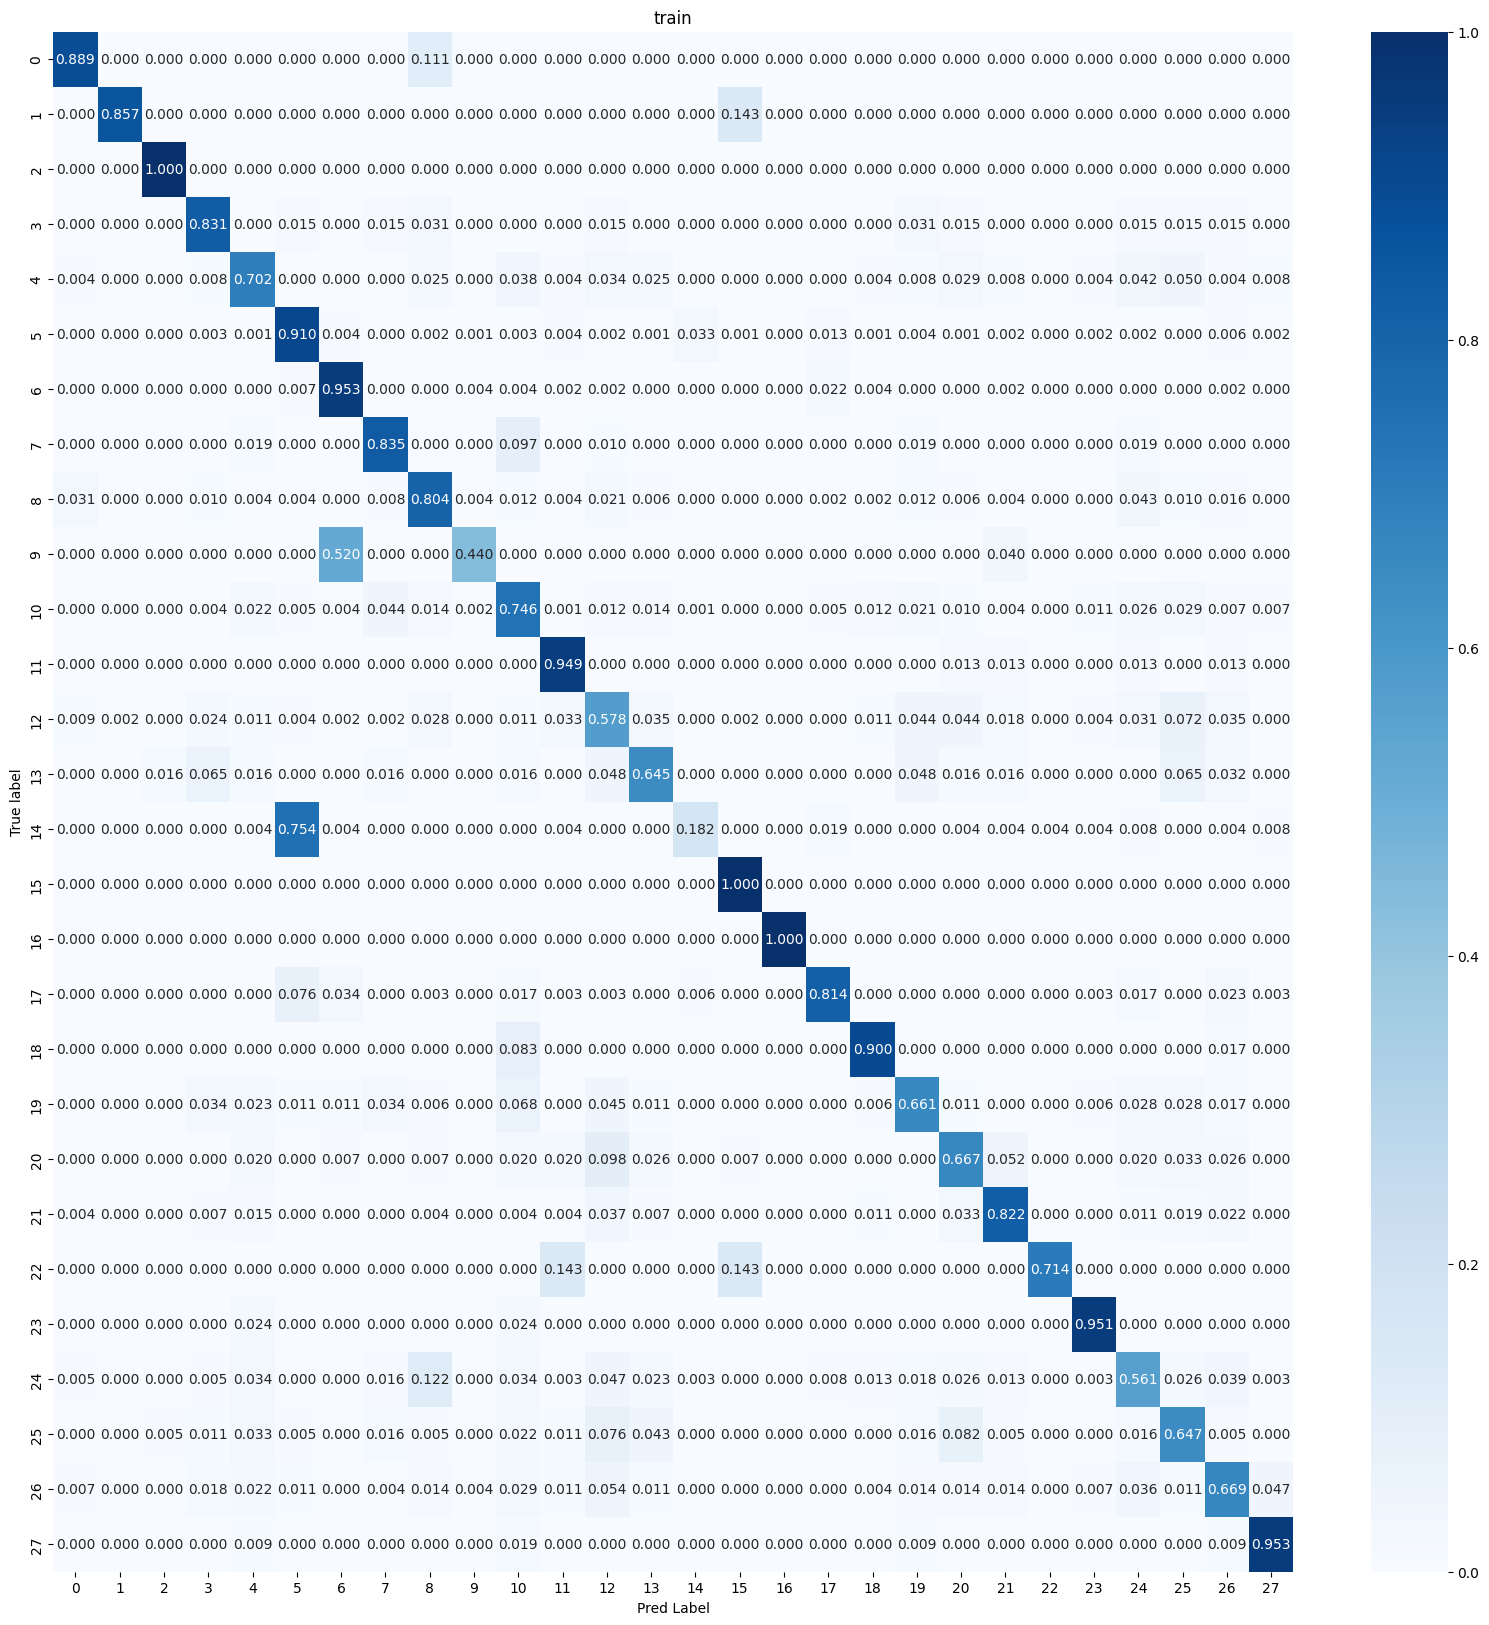

ValueError: Found input variables with inconsistent numbers of samples: [202, 2020]

In [41]:
# sift features

X_train1 = X_train[selected_features]
base_model=LogisticRegression(penalty='l1', C=0.2, solver='liblinear', class_weight=class_weight)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(base_model, X_train1, y_train['label'], cv=cv, scoring='accuracy')

print(f"cv scores: {cv_scores}")
print(f"mean: {cv_scores.mean():.4f}")
print(f"std: {cv_scores.std():.4f}")


base_model.fit(X_train1, y_train['label'])

# train predict
y_pred = base_model.predict(X_train1)

# report
print(classification_report(y_train['label'], y_pred))

classes=np.unique(y_train).astype(str)
plt.figure(figsize=(20, 20))
sns.heatmap(confusion_matrix(y_train['label'], y_pred,normalize='true'),
            annot=True, fmt='.3f', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('train')
plt.ylabel('True label')
plt.xlabel('Pred Label')
plt.show()

X_test2_1=X_test2_reduced[selected_features]

# test predict
y_pred = base_model.predict(X_test2_1)

# report
print(classification_report(y_test2_reduced['label'], y_pred,zero_division=1))
classes=np.unique(y_test2_reduced).astype(str)
plt.figure(figsize=(20, 20))
sns.heatmap(confusion_matrix(y_test2_reduced['label'], y_pred,normalize='true'),
            annot=True, fmt='.3f', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('test')
plt.ylabel('True label')
plt.xlabel('Pred Label')
plt.show()

cv scores: [0.7675 0.7695 0.761  0.7525 0.7635]
mean: 0.7628
std: 0.0059
              precision    recall  f1-score   support

           0       0.43      0.89      0.58        18
           1       0.86      0.86      0.86         7
           2       0.88      1.00      0.93         7
           3       0.66      0.94      0.78        65
           4       0.76      0.76      0.76       238
           5       0.95      0.92      0.93      4479
           6       0.92      0.96      0.94       553
           7       0.62      0.88      0.73       103
           8       0.83      0.85      0.84       516
           9       0.69      0.44      0.54        25
          10       0.91      0.79      0.84      1081
          11       0.68      0.96      0.80        78
          12       0.77      0.68      0.72       457
          13       0.49      0.79      0.60        62
          14       0.31      0.25      0.28       264
          15       0.76      1.00      0.87        26
        

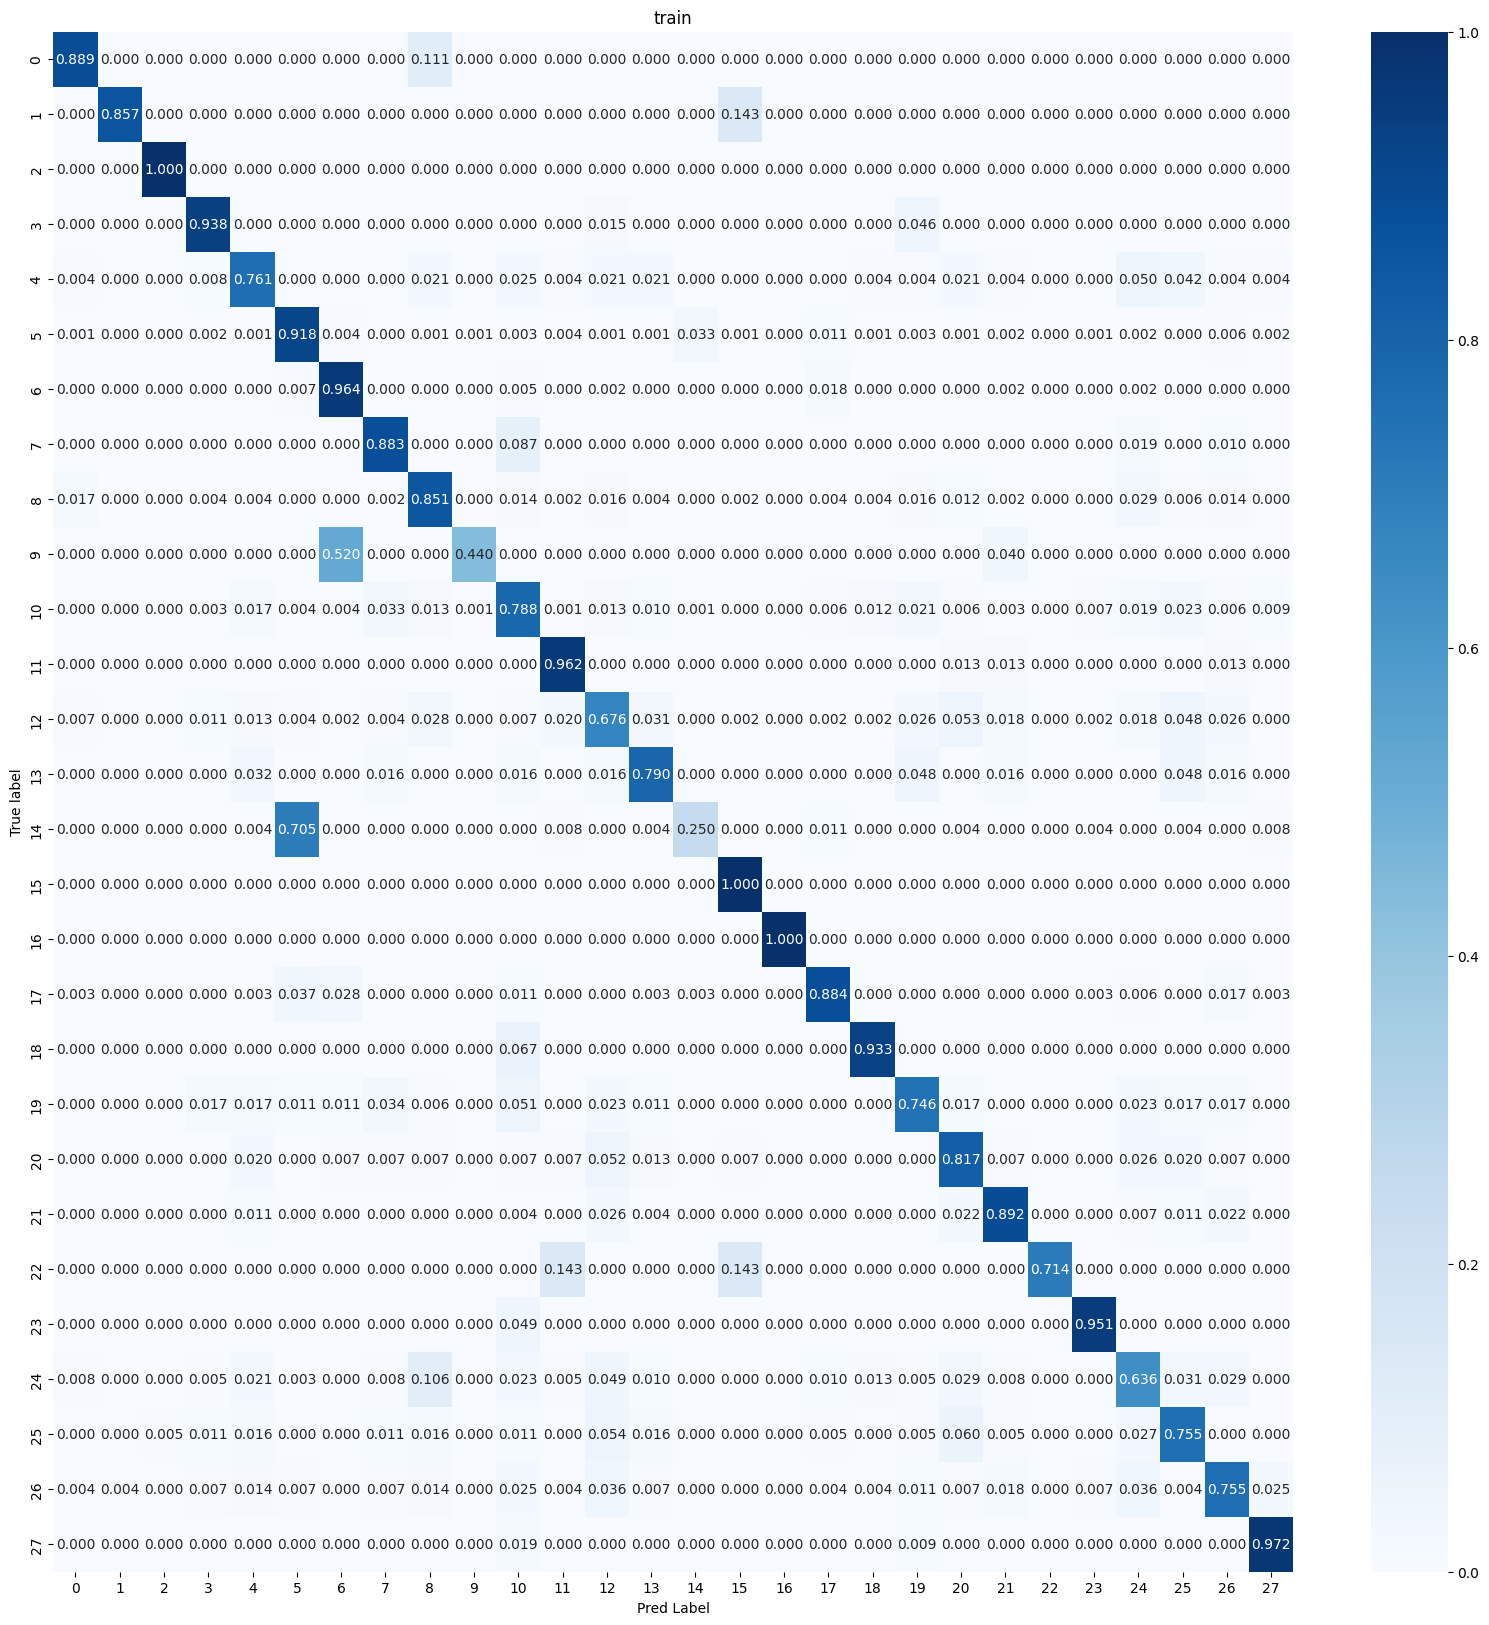

              precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           2       1.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.38      0.75      0.50         4
           5       0.60      1.00      0.75         9
           6       0.50      1.00      0.67         3
           7       0.90      0.64      0.75        14
           8       0.83      0.66      0.73        29
           9       1.00      0.00      0.00         3
          10       0.40      1.00      0.57         2
          11       1.00      0.89      0.94         9
          12       0.75      0.56      0.64        43
          13       0.11      1.00      0.20         1
          14       1.00      0.17      0.29         6
          15       1.00      0.00      0.00         1
          17       0.89      0.80      0.84        10
          18       0.00      0.00      0.00         1
          19       0.25    

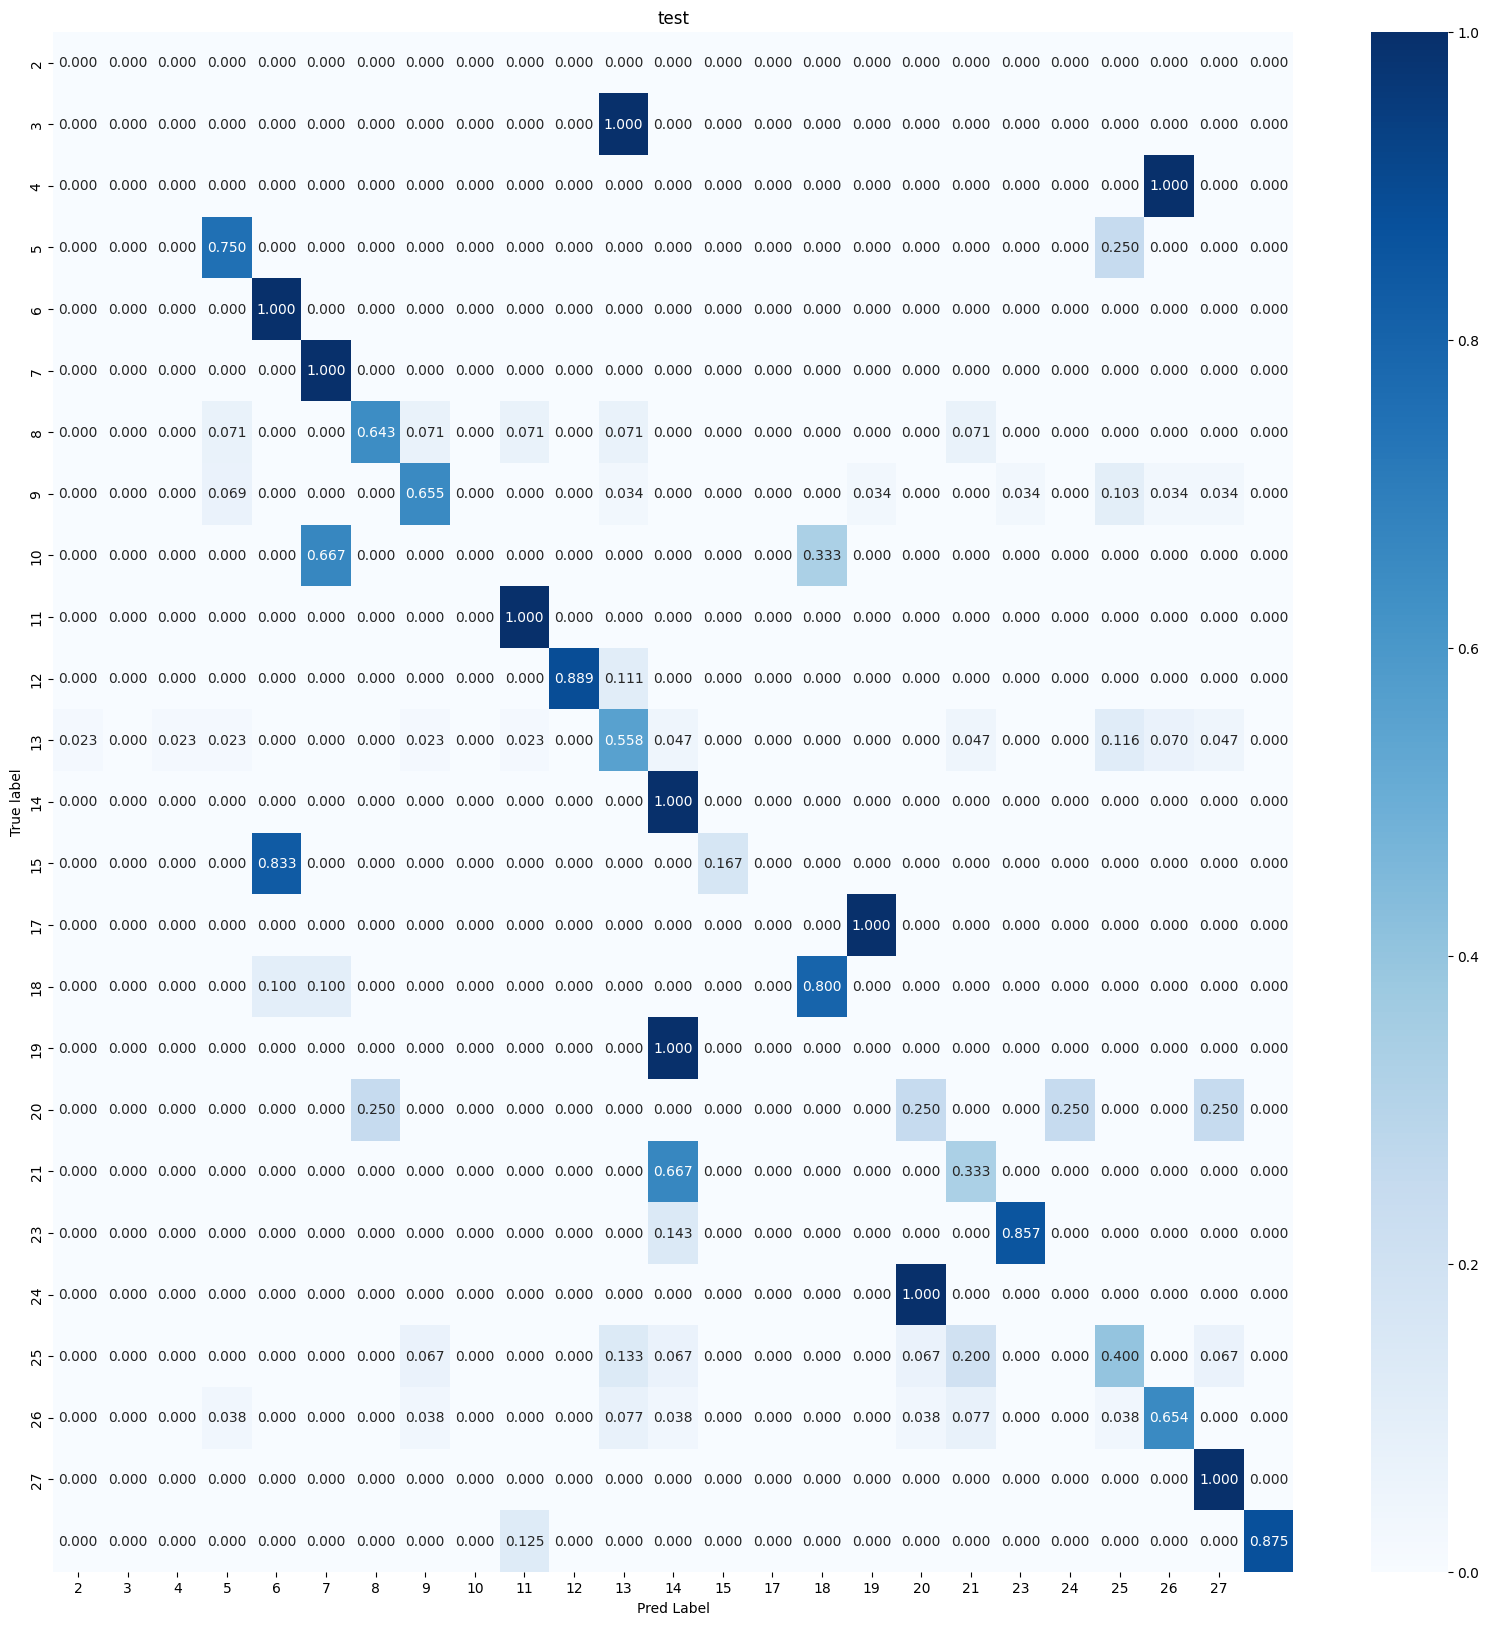

              precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           2       1.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.38      0.75      0.50         4
           5       0.60      1.00      0.75         9
           6       0.50      1.00      0.67         3
           7       0.90      0.64      0.75        14
           8       0.83      0.66      0.73        29
           9       1.00      0.00      0.00         3
          10       0.40      1.00      0.57         2
          11       1.00      0.89      0.94         9
          12       0.75      0.56      0.64        43
          13       0.11      1.00      0.20         1
          14       1.00      0.17      0.29         6
          15       1.00      0.00      0.00         1
          17       0.89      0.80      0.84        10
          18       0.00      0.00      0.00         1
          19       0.25    

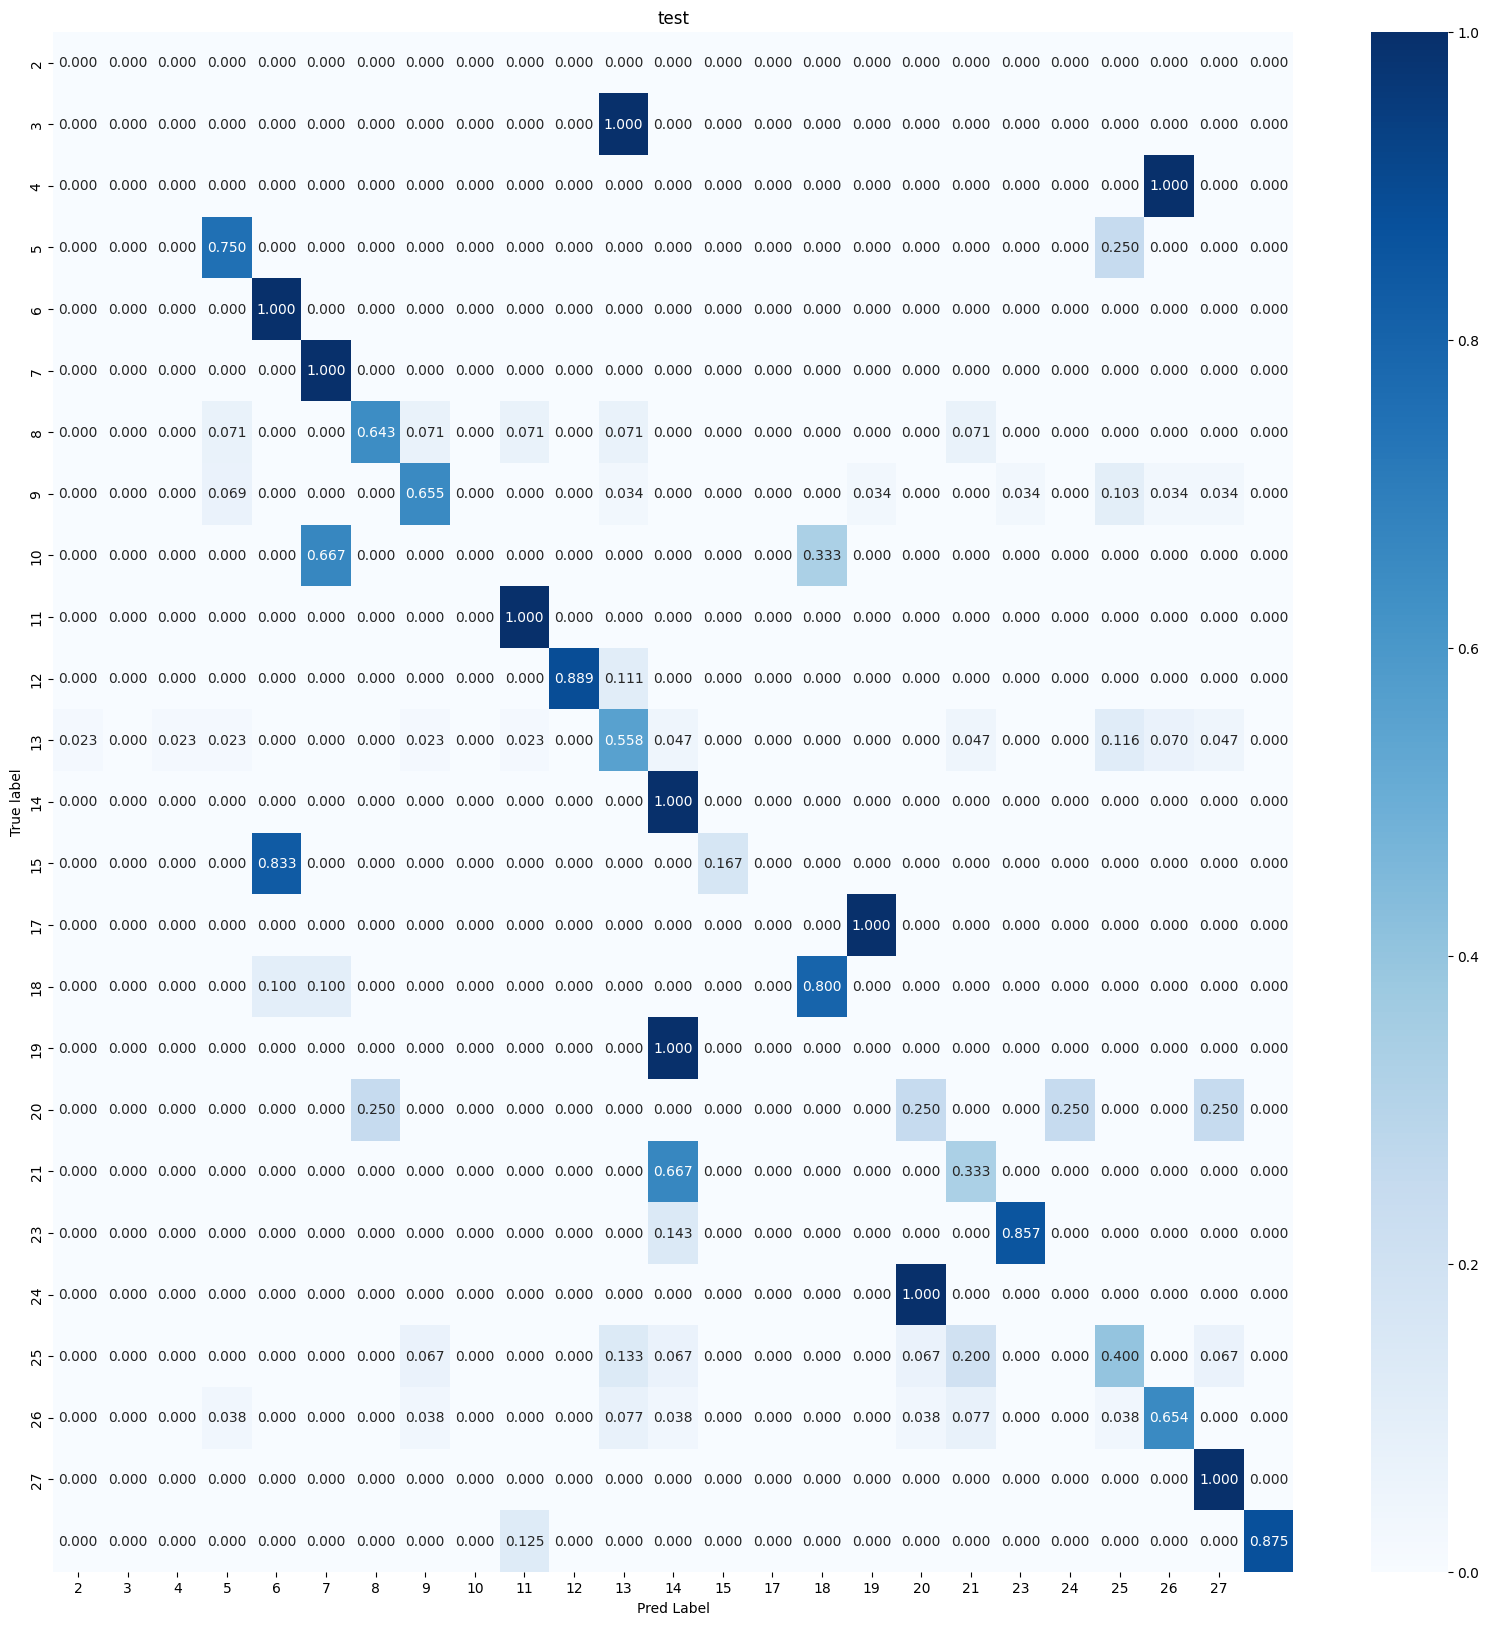

In [44]:
# keep features
base_model=LogisticRegression(penalty='l1', C=0.2, solver='liblinear', class_weight=class_weight)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(base_model, X_train, y_train['label'], cv=cv, scoring='accuracy')

print(f"cv scores: {cv_scores}")
print(f"mean: {cv_scores.mean():.4f}")
print(f"std: {cv_scores.std():.4f}")


base_model.fit(X_train, y_train['label'])

# train predict
y_pred = base_model.predict(X_train)

# report
print(classification_report(y_train['label'], y_pred))

classes=np.unique(y_train).astype(str)
plt.figure(figsize=(20, 20))
sns.heatmap(confusion_matrix(y_train['label'], y_pred,normalize='true'),
            annot=True, fmt='.3f', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('train')
plt.ylabel('True label')
plt.xlabel('Pred Label')
plt.show()


X_test2_2=X_test2_reduced

# test predict
y_pred = base_model.predict(X_test2_2)

# report
print(classification_report(y_test2_reduced['label'], y_pred,zero_division=1))
classes=np.unique(y_test2_reduced).astype(str)
plt.figure(figsize=(20, 20))
sns.heatmap(confusion_matrix(y_test2_reduced['label'], y_pred,normalize='true'),
            annot=True, fmt='.3f', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('test')
plt.ylabel('True label')
plt.xlabel('Pred Label')
plt.show()

In [45]:
X_train = X_train[selected_features]
X_test1 = X_test1[selected_features]
X_test2 = X_test2[selected_features]
y_train = y_train['label']
y_test2_reduced = y_test2_reduced['label']
